In [20]:
import pickle

import numpy as np
import pandas as pd
import sciplots as plots
from scipy.optimize import curve_fit

from src.utils import plot_config

In [22]:
with open('../data/study_6.pkl', 'rb') as file:
    data = pickle.load(file)

/tmp/ipykernel_25963/3745902241.py:2: DeprecationWarning: Transform is saved in old non-weights safe format and is deprecated, please resave the transform in the new format using net.save()
  data = pickle.load(file)
/tmp/ipykernel_25963/3745902241.py:2: DeprecationWarning: Network is saved from an old version and is deprecated, saving is not possible with this version
  data = pickle.load(file)
/tmp/ipykernel_25963/3745902241.py:2: DeprecationWarning: Network is saved from an old version and is deprecated, network weights may not load correctly, please resave the network in the new format using net.save()
  data = pickle.load(file)
/home/ethan_tregidga/PycharmProjects/Bayesian-DARKSKIES-Remote/src/utils/clustering.py:254: DeprecationWarning: Network is saved from an old version and is deprecated, please resave the network in the new format using net.save()
  super().__setstate__(state)
/home/ethan_tregidga/PycharmProjects/Bayesian-DARKSKIES-Remote/src/utils/clustering.py:254: Deprecat

In [72]:
x_data = np.array([1, 2, 3, 7, 10, 20, 50, 100])
idxs = np.arange(len(data)).reshape(len(x_data), -1)
loss_means = np.empty((int(len(data) / len(x_data)), len(x_data), 2))
loss_stes = loss_means.copy()

for shape in np.ndindex(loss_means.shape[:2]):
    loss_means[*shape] = np.mean(data[shape[0] * loss_means.shape[1] + shape[1]]['losses'], axis=0)
    loss_stes[*shape] = np.std(data[shape[0] * loss_means.shape[1] + shape[1]]['losses'], axis=0, ddof=1) / np.sqrt(len(data[shape[0] * loss_means.shape[1] + shape[1]]['losses']))

loss_means.shape, loss_stes.shape

((5, 8, 2), (5, 8, 2))

In [84]:
def arctan_fit(x, a, b, c):
    return a + np.arctan((x - b) / c)

def inv_arctan_fit(y, a, b, c):
    return np.tan(y - a) * c + b

popts = []
pcovs = []
model_means = []
model_x_data = 10 ** np.linspace(np.log10(x_data[0]), np.log10(x_data[-1]), 1000)

for loss_mean, loss_ste in zip(loss_means[..., 0], loss_stes[..., 0]):
    popt, pcov = curve_fit(
        arctan_fit,
        x_data,
        loss_mean,
        sigma=loss_ste,
        p0=[0, 0, 1],
    )
    popts.append(popt)
    pcovs.append(pcov)
    model_means.append(arctan_fit(model_x_data, *popt))
    print(f'Max Accuracy: {np.max(loss_mean):.2%} +/- {np.max(loss_ste):.2%}\tAsymptotic Accuracy: {arctan_fit(6, *popt):.2%}')

popts = np.array(popts)
pcovs = np.array(pcovs)
model_means = np.array(model_means)
model_means.shape, popts.shape, pcovs.shape

Max Accuracy: 45.92% +/- 0.30%	Asymptotic Accuracy: 45.63%
Max Accuracy: 54.17% +/- 0.50%	Asymptotic Accuracy: 53.49%
Max Accuracy: 51.93% +/- 0.98%	Asymptotic Accuracy: 50.74%
Max Accuracy: 54.90% +/- 0.52%	Asymptotic Accuracy: 54.21%
Max Accuracy: 60.84% +/- 0.28%	Asymptotic Accuracy: 59.90%


((5, 1000), (5, 3), (5, 3, 3))

In [96]:
sigmas = np.sqrt(np.diagonal(pcovs, axis1=1, axis2=2))
scaled_popts = popts
pd.DataFrame(
    np.stack((popts, sigmas), axis=-1).reshape(5, -1),
    columns=['a', '+/-', 'b', '+/-', 'c', '+/-'],
    index=['BAHAMAS', '+AGN', '+DARKSKIES', '+FLAMINGO', '+TNG'],
).round(5)

,a,+/-,b,+/-,c,+/-
BAHAMAS,-1.11421,0.00091,0.96678,0.06552,0.00153,0.00303
+AGN,-1.02820,0.00094,0.75436,0.05391,0.04026,0.00892
+DARKSKIES,-1.05305,0.00124,0.71016,0.03772,0.05482,0.00660
+FLAMINGO,-1.02165,0.00064,0.86211,0.00837,0.03623,0.00208
+TNG,-0.96266,0.00042,0.86021,0.00528,0.04683,0.00177


In [90]:
# np.round(np.tan(0.95 * (model_means[:, -1] - model_means[:, 0]) + model_means[:, 0] - popts[:, 0]) * popts[:, 2] + popts[:, 1], 2)
np.round(np.tan(0.98 * model_means[:, -1] - popts[:, 0]) * popts[:, 2] + popts[:, 1], 2)

array([1.13, 4.33, 5.74, 4.06, 4.57])

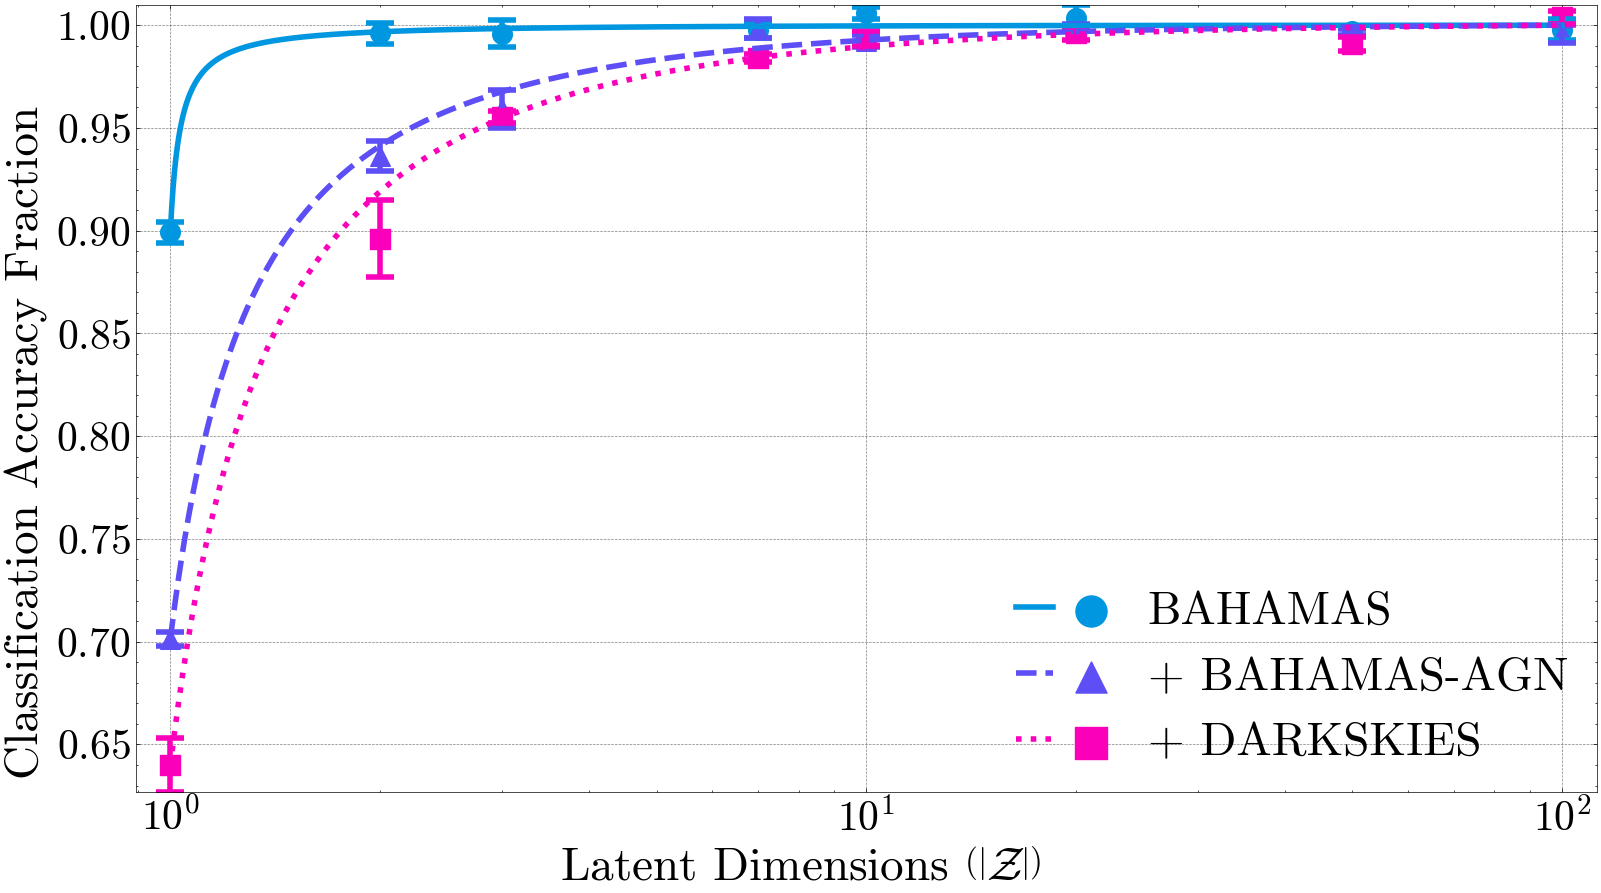

In [91]:
slice_ = slice(3)
plot = plots.PlotPlots(
    [x_data] * len(loss_means[slice_]) + [model_x_data] * len(loss_means[slice_]),
    # [*loss_means[slice_, :, 0] * 100, *model_means[slice_] * 100],
    [*(loss_means[..., 0] / model_means[:, -1:])[slice_], *(model_means / model_means[:, -1:])[slice_]],
    # [
    #     *((loss_means[..., 0] - model_means[:, :1]) / (model_means[:, -1:] - model_means[:, :1]))[slice_],
    #     *((model_means - model_means[:, :1]) / (model_means[:, -1:] - model_means[:, :1]))[slice_],
    # ],
    log_x=True,
    x_label=r'Latent Dimensions $\left(\left|\mathcal{Z}\right|\right)$',
    # y_label='Classification Accuracy (%)',
    y_label='Classification Accuracy Fraction',
    styles=['o', '^', 's'] + ['-', '--', ':'],
    labels=['BAHAMAS', '+ BAHAMAS-AGN', '+ DARKSKIES', '+ FLAMINGO', '+ TNG'][slice_] * 2,
    # y_error=[*loss_stes[slice_, :, 0] * 100, *[None] * len(loss_means[slice_])],
    # y_error=[*(loss_stes[..., 0] / (model_means[:, -1:] - model_means[:, :1]))[slice_], *[None] * len(loss_means[slice_])],
    y_error=[*(loss_stes[..., 0] / model_means[:, -1:])[slice_], *[None] * len(loss_means[slice_])],
    colours=(plot_config.BAHAMAS[2:3] + plot_config.BAHAMAS_AGN[:1] + plot_config.FLAMINGO_TEST +
             plot_config.FLAMINGO[:1] + plot_config.FLAMINGO[-1:])[slice_] * 2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    cap_size=10,
    line_width=4,
    eline_width=4,
    alpha_marker=1,
    axis=True,
    markers=True,
    frameon=False,
    cols=1,
    loc='lower right'
)
plot.axes.set_xlim(10 ** -0.05, 10 ** 2.05)
# plot.axes.set_ylim(32, 55)
plot.savefig('../plots/final_plots/', name='latent_dim_optimisation')